In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [43]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5


In [44]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
        "PlantVillage",
        shuffle=True,
        image_size = (IMAGE_SIZE,IMAGE_SIZE),
        batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [45]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [46]:
len(dataset)

68

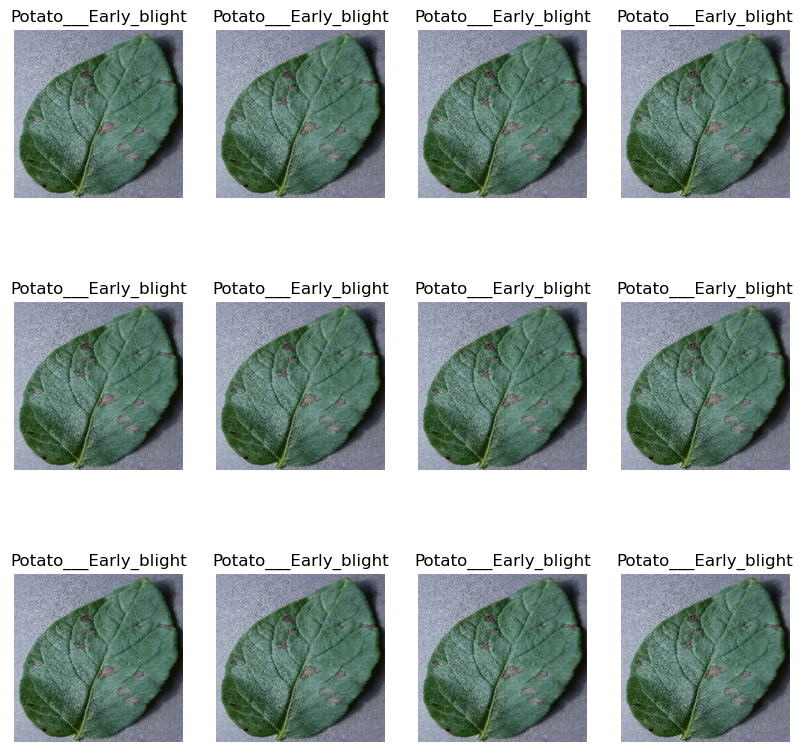

In [47]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[0]])
        plt.axis("off")

In [48]:
#80% = training
# 20% = 10% validation,10%test

In [49]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [50]:
train_ds = dataset.take(54)
len(train_ds)

54

In [51]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [52]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [53]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [54]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [55]:
 def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
        ds_size = len(ds)
        
        if shuffle:
            ds = ds.shuffle(shuffle_size,seed=12)
        
        train_size = int(train_split*ds_size)
        val_size = int(val_split*ds_size)
        
        train_ds = ds.take(train_size)
        
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)
        
        return train_ds,val_ds,test_ds

In [56]:
train_ds , val_ds , test_ds = get_dataset_partitions_tf(dataset)

In [57]:
len(train_ds)

54

In [58]:
len(val_ds)

6

In [59]:
len(test_ds)

8

In [60]:
#caching and prefetching -- save time for loading the images
#  read the image from the disk for the next iteration when need same img it will keep that image in the memory
# improve the performance

# Optimize for training processes
    
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [61]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [62]:
# data augmentation - to make our model robust(prediction more images in term of rotation ,zoom, flip , contrast,)
#        to reduce overfitting
#        modified copies of existing data
 
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

    
    

In [63]:
# softmax activation function is it will normalize the probability of your classes

n_classes = 3
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3) , activation='relu'),
    layers.MaxPooling2D((2,2,)),
    layers.Conv2D(64, (3,3) , activation='relu'),
    layers.MaxPooling2D((2,2,)),
    
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
    
])

model.build(input_shape=input_shape)



In [64]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [65]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [66]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds)

Epoch 1/5
54/54 [==============================] - 45s 738ms/step - loss: 0.9035 - accuracy: 0.4832 - val_loss: 0.8230 - val_accuracy: 0.4896
Epoch 2/5
54/54 [==============================] - 36s 674ms/step - loss: 0.7447 - accuracy: 0.6331 - val_loss: 0.6273 - val_accuracy: 0.7500
Epoch 3/5
54/54 [==============================] - 35s 651ms/step - loss: 0.5508 - accuracy: 0.7627 - val_loss: 0.5366 - val_accuracy: 0.7604
Epoch 4/5
54/54 [==============================] - 33s 605ms/step - loss: 0.4481 - accuracy: 0.8142 - val_loss: 0.3558 - val_accuracy: 0.8594
Epoch 5/5
54/54 [==============================] - 34s 639ms/step - loss: 0.2680 - accuracy: 0.8981 - val_loss: 0.3611 - val_accuracy: 0.8542


In [69]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 185ms/step - loss: 0.4059 - accuracy: 0.8125


In [70]:
scores

[0.40586358308792114, 0.8125]

In [71]:
history

In [72]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [73]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [74]:
history.history['accuracy']

[0.48321759700775146,
 0.6331018805503845,
 0.7627314925193787,
 0.8142361044883728,
 0.8981481194496155]

In [75]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

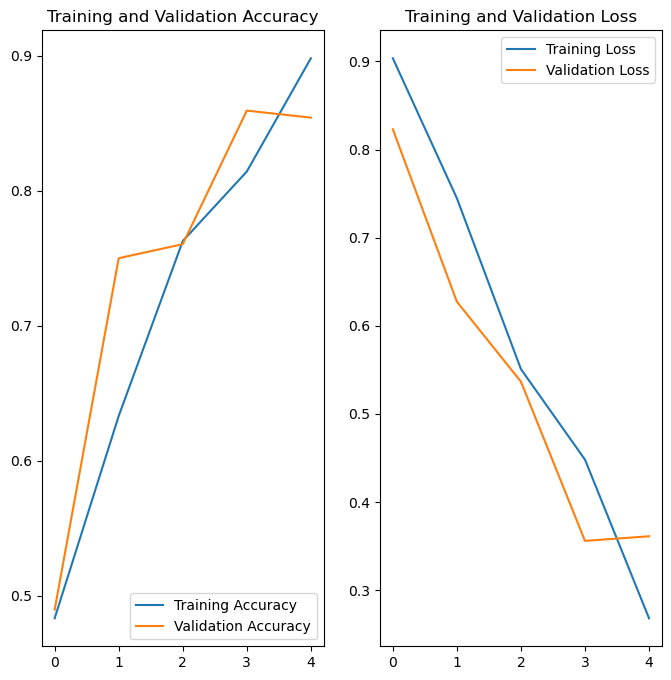

In [82]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [83]:
np.argmax([0.1281113 , 0.23986493, 0.63202375])

2

first image to predict
actual lanel:  Potato___Late_blight
1/1 [==============================] - 0s 434ms/step
Potato___Early_blight


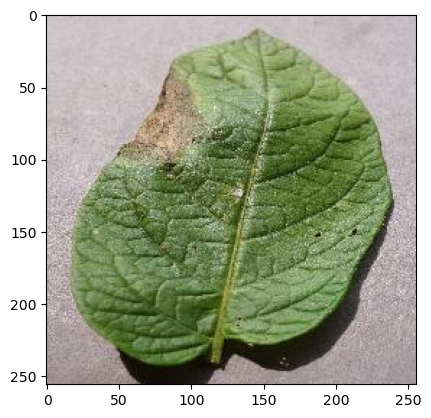

In [84]:
# make predictions on sample imges

import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    
    print("actual lanel: ",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    
    #print(batch_prediction[0])
    # nclasses = 3 (probability) which one is max [0.1281113  0.23986493 0.63202375]
    
    print("predicted label:  ",class_names[np.argmax(batch_prediction[0])])
    
    
    

In [85]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 74ms/step


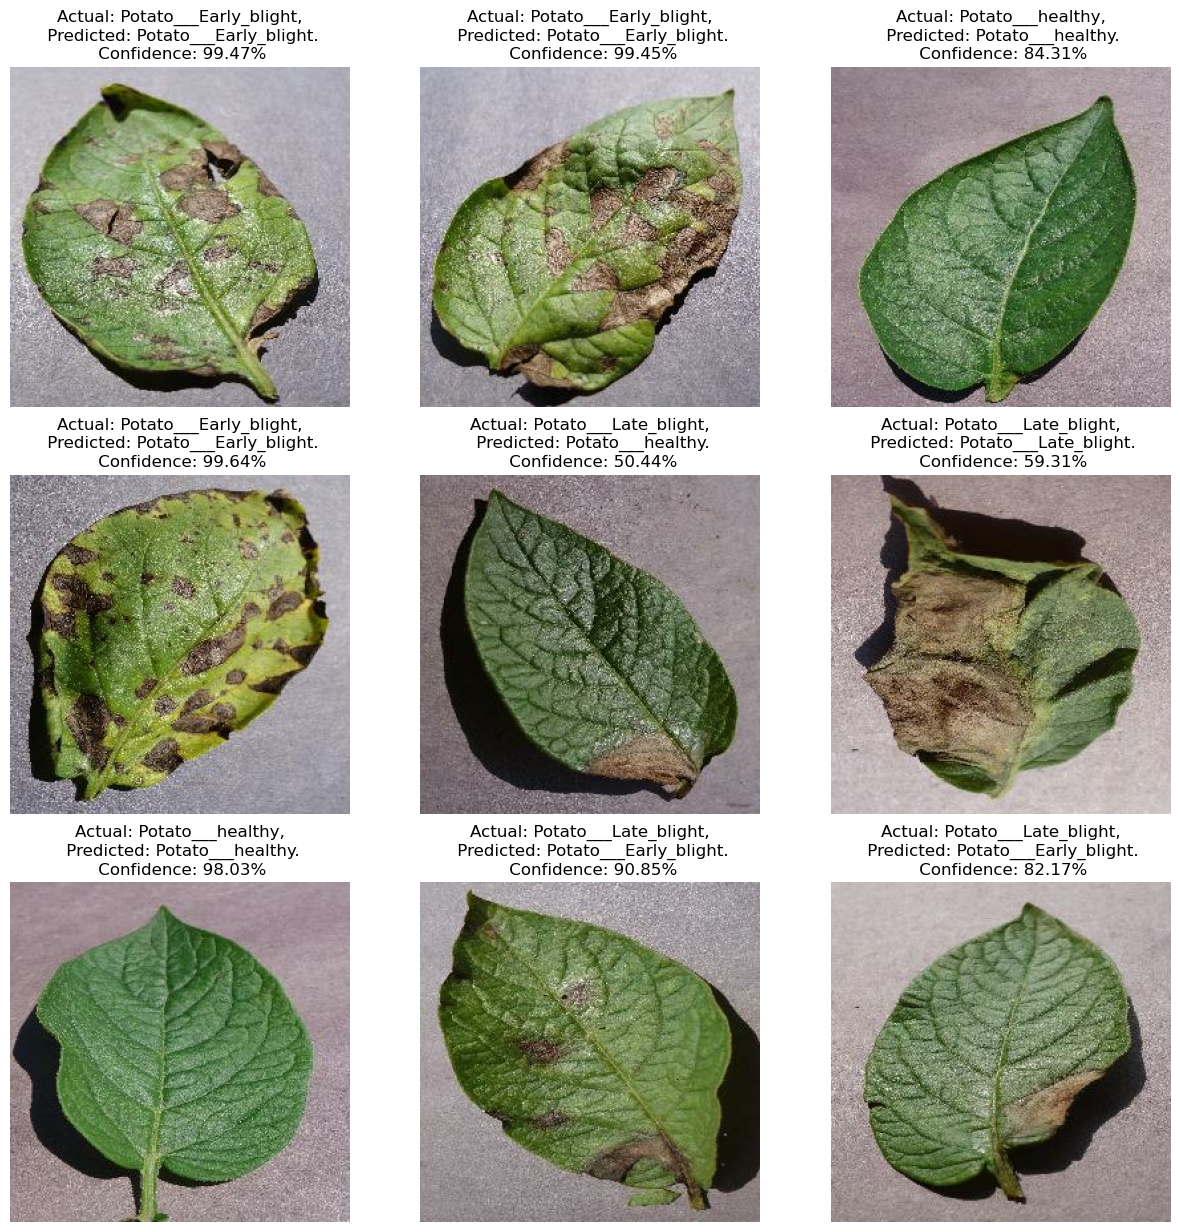

In [86]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [92]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
